# Imports, loading features and DB

In [93]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from metrics.metrics import get_tp_fp_fn, quick_circle_comparison, circle_comparison
import matplotlib.pyplot as plt

In [94]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        # big max_lesion_diam_mm needed to include clusters of mC
        max_lesion_diam_mm=10000000.0,
        partitions=['train'],
        extract_patches=False,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

# Classification

In [95]:
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler


from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [96]:
def sensitivity(y_true, y_pred):
    TP = np.sum(y_true & y_pred)
    FN = np.sum(y_true&(~y_pred))
    if TP + FN == 0:
        return 0
    return TP/(TP + FN)

In [97]:
gabor_lbp_features = pd.concat(pd.read_pickle('../data/hough_gabor_features/gabor_train_all_14px_big_diam_size.pkl'))
all_data_df = gabor_lbp_features.sample(frac=1) # shuffle df
data = all_data_df

# needed after training to access all candidates features
data_backed_up = data.copy()

data.head(5)

img_energy  img_entropy  img_uniformity   img_min  img_10th_perc  \
604    92.607853     6.836300        0.009944  0.629744       0.657546   
46    151.797515     6.839641        0.010360  0.798021       0.848403   
53    129.961467     6.823594        0.010256  0.760890       0.784291   
1400   83.197753     7.101805        0.008017  0.574153       0.611405   
1147   95.933690     6.640562        0.011401  0.627521       0.676378   

      img_90th_perc   img_max  img_mean  img_meadian  \
604        0.722418  0.657546  0.686952     0.684025   
46         0.911606  0.848403  0.879706     0.878093   
53         0.843142  0.784291  0.813962     0.814180   
1400       0.687853  0.611405  0.650863     0.651130   
1147       0.722994  0.676378  0.699272     0.699462   

      img_inter_quartile_range  ...    kurt_4     energy_5    mean_5  \
604                   0.028354  ...  0.349870   933.819702  2.165920   
46                    0.035762  ... -1.059251  1438.439819  2.700872   
53                    0.029194  ... -0.482460  1240.146851  2.507758   
1400                  0.038577  ... -0.119192   800.778442  2.004217   
1147                  0.026109  ...  0.155091   941.149231  2.185038   

         std_5    skew_5    kurt_5  candidate_coordinates  \
604   0.270515  0.262480 -0.875297           [52, 747, 4]   
46    0.210398 -0.070329 -1.113444       [1074, 1310, 19]   
53    0.196036 -0.010465 -0.936745        [501, 1480, 19]   
1400  0.262144 -0.107957 -1.038423         [136, 1226, 6]   
1147  0.165502 -0.234612 -0.398843         [478, 1322, 7]   

                 patch_coordinates  patch_mask_intersection    img_id  
604         ((740, 754), (45, 59))                        0  24065914  
46    ((1303, 1317), (1067, 1081))                        0  24065860  
53      ((1473, 1487), (494, 508))                        0  20587902  
1400    ((1219, 1233), (129, 143))                        0  27829188  
1147    ((1315, 1329), (471, 485))                        0  22579893  

[5 rows x 51 columns]

Sampling dataset to obtain a desired `positive x negative` proportion in the training df

In [98]:
neg2pos_proportion = 1

pos_data = data[data.patch_mask_intersection>0]
neg_data = data[data.patch_mask_intersection==0].sample(neg2pos_proportion*len(pos_data))
data = pd.concat([pos_data, neg_data]).sample(frac=1)
data

img_energy  img_entropy  img_uniformity   img_min  img_10th_perc  \
958   103.306477     6.589542        0.011870  0.685518       0.704156   
617    41.482971     6.582645        0.011429  0.486776       0.525349   
457    98.800530     6.794974        0.010100  0.644214       0.681347   
413    74.668631     6.966451        0.009007  0.557427       0.587672   
424   118.683841     6.552377        0.012391  0.740183       0.756164   
...          ...          ...             ...       ...            ...   
200    78.989189     6.992061        0.008642  0.588298       0.605496   
1233   35.836588     6.657237        0.011922  0.397408       0.408979   
743    49.618700     6.445379        0.012472  0.563160       0.599745   
23    127.269364     6.687931        0.011454  0.752902       0.780058   
171    91.795117     7.300884        0.006768  0.584301       0.615276   

      img_90th_perc   img_max  img_mean  img_meadian  \
958        0.747215  0.704156  0.725812     0.725578   
617        0.567964  0.525349  0.544065     0.541605   
457        0.738342  0.681347  0.709567     0.712435   
413        0.651225  0.587672  0.616753     0.615812   
424        0.800913  0.756164  0.777926     0.776256   
...             ...       ...       ...          ...   
200        0.665603  0.605496  0.634404     0.632624   
1233       0.447701  0.408979  0.427342     0.425640   
743        0.656534  0.599745  0.627129     0.627594   
23         0.830846  0.780058  0.805539     0.802861   
171        0.783175  0.615276  0.681324     0.664555   

      img_inter_quartile_range  ...    kurt_4     energy_5    mean_5  \
958                   0.020566  ... -1.067655  1001.784668  2.251574   
617                   0.023848  ... -0.616872   398.091614  1.677921   
457                   0.032060  ... -1.042383  1009.035828  2.260517   
413                   0.032542  ... -0.378493   714.751099  1.901256   
424                   0.023288  ... -0.439211  1144.972290  2.393502   
...                        ...  ...       ...          ...       ...   
200                   0.035195  ... -0.839770   760.816895  1.942768   
1233                  0.015813  ... -0.490672   349.533569  1.319184   
743                   0.031398  ... -1.011342   479.669037  1.943585   
23                    0.028711  ... -0.904229  1220.964355  2.487079   
171                   0.083157  ... -0.818294   907.313660  2.087679   

         std_5    skew_5    kurt_5  candidate_coordinates  \
958   0.203866  0.289521 -0.304553       [1041, 1944, 11]   
617   0.167611 -0.125508 -1.202006           [3, 1549, 4]   
457   0.195459  0.113234 -0.631129         [593, 2188, 4]   
413   0.178648  0.741493  0.018844         [441, 2063, 9]   
424   0.335925  0.369535 -0.936246         [102, 1540, 4]   
...        ...       ...       ...                    ...   
200   0.327678  0.581952 -0.369906        [123, 2009, 13]   
1233  0.207578  0.783665 -0.236168        [1478, 2203, 4]   
743   0.171396 -0.322236 -1.198238            [2, 677, 9]   
23    0.209400  0.424393 -0.778233        [649, 1821, 19]   
171   0.520336  0.447196 -0.772402        [504, 2059, 13]   

                 patch_coordinates  patch_mask_intersection    img_id  
958   ((1937, 1951), (1034, 1048))                        0  20588072  
617        ((1542, 1556), (0, 10))                        0  20587200  
457     ((2181, 2195), (586, 600))                        0  20587928  
413     ((2056, 2070), (434, 448))                        0  22678953  
424      ((1533, 1547), (95, 109))                        0  26933801  
...                            ...                      ...       ...  
200     ((2002, 2016), (116, 130))                      196  22670465  
1233  ((2196, 2210), (1471, 1485))                        0  22679036  
743           ((670, 684), (0, 9))                        0  22614499  
23      ((1814, 1828), (642, 656))                       22  22613970  
171     ((2052, 2066), (497, 511))                    

### LOO cross validation per patient 

In [99]:
f1_metrics = []
rocauc_metrics = []
full_test_prediction = []

final_metrics_dfs = []

# getting all case_ids for images we extracted features from
data_case_ids = db.df[db.df.img_id.isin(data.img_id.unique())].case_id.unique()

for test_case_id in tqdm(data_case_ids):
    
    # filtering dataset based on train/test patient (and all their images)
    test_img_ids = db.df[db.df.case_id == test_case_id].img_id.values
    test_mask = data.img_id.isin(test_img_ids)
    train_df = data[~test_mask]
    test_df = data[test_mask]

    train_X, train_y = train_df.drop(columns=['patch_mask_intersection','candidate_coordinates', 'patch_coordinates', 'img_id']), (train_df.patch_mask_intersection>0).values.astype(int)
    test_X, test_y = test_df.drop(columns=['patch_mask_intersection','candidate_coordinates', 'patch_coordinates', 'img_id']), (test_df.patch_mask_intersection>0).values.astype(int)

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)
    
    svc = SVC(C=10, probability=True)
    svc.fit(train_X_scaled, train_y)

    train_y_predicted = svc.predict(train_X_scaled)
    # train_y_predicted_proba = svc.predict_proba(train_X_scaled)
    
    
    # doing predictions image-wise, not patient wise
    for patient_image_id in test_img_ids:
        
        # selecting separete images for evaluation
        image_test_X_scaled = test_X_scaled[test_df.img_id == patient_image_id]
        image_test_y = test_y[test_df.img_id == patient_image_id]
        
        test_y_predicted = svc.predict(image_test_X_scaled)
        # test_y_predicted_proba = svc.predict_proba(image_test_X_scaled)
        
        f1_metrics.append((f1_score(train_y, train_y_predicted), f1_score(image_test_y, test_y_predicted)))
        
        # doing prediction of ALL test candidates 
        all_test_candidates = data_backed_up[data_backed_up.img_id == patient_image_id]
        
        final_metrics_df = all_test_candidates[['candidate_coordinates', 'patch_coordinates', 'patch_mask_intersection', 'img_id']].copy()
        
        all_test_X, all_test_y = all_test_candidates.drop(columns=['patch_mask_intersection', 'candidate_coordinates', 'patch_coordinates', 'img_id']), (all_test_candidates.patch_mask_intersection>0).values.astype(int)
        all_test_X_scaled = scaler.transform(all_test_X)
        all_test_y_predicted = svc.predict(all_test_X_scaled)
        
        final_metrics_df['target'] = all_test_y
        final_metrics_df['target_pred'] = all_test_y_predicted
        final_metrics_df['target_pred_proba'] = svc.predict_proba(all_test_X_scaled)[:,1]
        final_metrics_dfs.append(final_metrics_df)
        full_test_prediction.append((all_test_y, all_test_y_predicted))
    
f1_metrics = np.array(f1_metrics)

  6%|▌         | 3/50 [00:20<05:21,  6.83s/it]/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
 78%|███████▊  | 39/50 [04:28<01:15,  6.84s/it]/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
100%|██████████| 50/50 [05:41<00:00,  6.84s/it]


F1 scores median:  [0.8486776  0.85714286]
F1 scores mean:  [0.84841394 0.77180867]


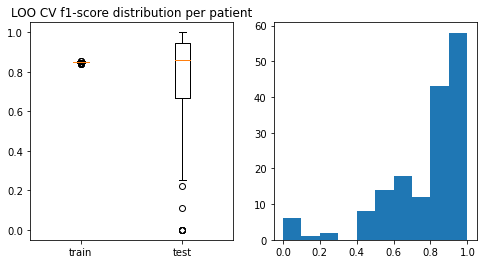

In [100]:
print('F1 scores median: ', np.median(f1_metrics, axis=0))
print('F1 scores mean: ', np.mean(f1_metrics, axis=0))

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].boxplot(f1_metrics, labels=['train', 'test'])
ax[0].set_title('LOO CV f1-score distribution per patient')

ax[1].hist(np.array(f1_metrics)[:,1])
plt.show()

sensitivity for all candidates per patient
mean: 0.853506817734238	median 1.0

#FP per candidate mean: 90.32716049382717 median: 59.0


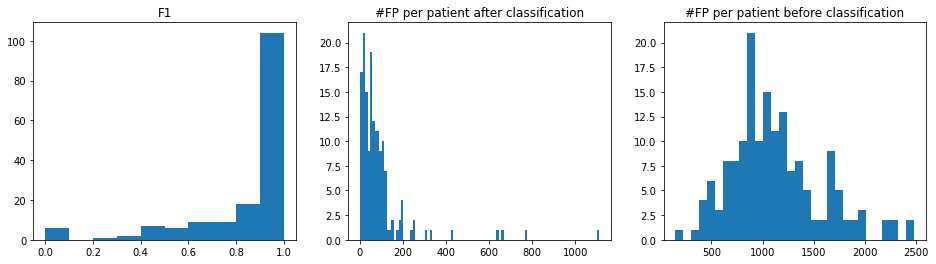

In [101]:
# sensitivity for all test candidates per patient
all_f1 = [sensitivity(x, y) for x, y in full_test_prediction]
print(f'sensitivity for all candidates per patient\nmean: {np.mean(all_f1)}\tmedian {np.median(all_f1)}')


FP_number_reduced = [np.sum(y&(~x)) for x, y in full_test_prediction]
FP_number_original = [len(y) - np.sum(x) for x, y in full_test_prediction]

print(f'\n#FP per candidate mean: {np.mean(FP_number_reduced)} median: {np.median(FP_number_reduced)}')


fig, ax = plt.subplots(1, 3, figsize=(16,4))

ax[0].hist(all_f1)
ax[0].set_title('F1')


ax[1].set_title('#FP per image after classification')
ax[1].hist(FP_number_reduced, bins=100)
ax[2].set_title('#FP per image before classification')
ax[2].hist(FP_number_original, bins=30)
plt.show()

In [102]:
froc_df = pd.concat(final_metrics_dfs)
froc_df

candidate_coordinates             patch_coordinates  \
593        [655, 1642, 16]    ((1635, 1649), (648, 662))   
1255        [450, 1521, 3]    ((1514, 1528), (443, 457))   
495       [1247, 1342, 19]  ((1335, 1349), (1240, 1254))   
1317         [70, 2964, 3]      ((2957, 2971), (63, 77))   
1346          [49, 641, 3]        ((634, 648), (42, 56))   
...                    ...                           ...   
815       [1350, 1559, 10]  ((1552, 1566), (1343, 1357))   
240        [950, 1599, 19]    ((1592, 1606), (943, 957))   
166       [1121, 1834, 17]  ((1827, 1841), (1114, 1128))   
341         [956, 1415, 6]    ((1408, 1422), (949, 963))   
531         [246, 1546, 3]    ((1539, 1553), (239, 253))   

      patch_mask_intersection    img_id  target  target_pred  \
593                         0  20586908       0            0   
1255                        0  20586908       0            0   
495                         0  20586908       0            0   
1317                        0  20586908       0            0   
1346                        0  20586908       0            0   
...                       ...       ...     ...          ...   
815                         0  30011674       0            0   
240                         0  30011674       0            0   
166                         0  30011674       0            0   
341                         0  30011674       0            0   
531                         0  30011674       0            0   

      target_pred_proba  
593            0.080913  
1255           0.057814  
495            0.149301  
1317           0.095204  
1346           0.117492  
...                 ...  
815            0.312650  
240            0.178657  
166            0.557138  
341            0.155787  
531            0.093991  

[185972 rows x 7 columns]

In [103]:
image_froc_df

candidate_coordinates             patch_coordinates  \
832        [951, 1517, 4]    ((1510, 1524), (944, 958))   
444       [769, 1568, 15]    ((1561, 1575), (762, 776))   
316       [308, 2395, 17]    ((2388, 2402), (301, 315))   
705        [993, 1603, 3]   ((1596, 1610), (986, 1000))   
652       [1099, 887, 10]    ((880, 894), (1092, 1106))   
..                    ...                           ...   
815      [1350, 1559, 10]  ((1552, 1566), (1343, 1357))   
240       [950, 1599, 19]    ((1592, 1606), (943, 957))   
166      [1121, 1834, 17]  ((1827, 1841), (1114, 1128))   
341        [956, 1415, 6]    ((1408, 1422), (949, 963))   
531        [246, 1546, 3]    ((1539, 1553), (239, 253))   

     patch_mask_intersection    img_id  target  target_pred  target_pred_proba  
832                        0  30011674       0            0           0.106900  
444                        0  30011674       0            0           0.105254  
316                        0  30011674       0            0           0.062562  
705                        0  30011674       0            0           0.193745  
652                        0  30011674       0            0           0.371666  
..                       ...       ...     ...          ...                ...  
815                        0  30011674       0            0           0.312650  
240                        0  30011674       0            0           0.178657  
166                        0  30011674       0            0           0.557138  
341                        0  30011674       0            0           0.155787  
531                        0  30011674       0            0           0.093991  

[886 rows x 7 columns]

In [104]:
froc_aggr_all = []
FN = []
for img_id in tqdm(froc_df.img_id.unique()):
# for img_id in tqdm([24055203]):
    img_index = db.df[db.df.img_id == img_id].index.values[0]

    lesion_mask = db[img_index]['lesion_mask']

    image_froc_df = froc_df[froc_df.img_id == img_id]
    
    fp_patches = []
    tp_patches = []
    # iterating over patches and checking if the mask instersection is not zero
    tp_rois_dict = {}
    for patch_idx, patch in enumerate(image_froc_df.patch_coordinates.values):
        (px1, px2), (py1, py2) = patch
        mask_rois_in_patch = set(lesion_mask[px1:px2, py1:py2].ravel()).difference(set([0]))

        if len(mask_rois_in_patch) == 0:
            patch_fp_dict =  image_froc_df.iloc[patch_idx].to_dict()
            patch_fp_dict['type'] = 'FP'
            fp_patches.append(patch_fp_dict)
        else:
            for mask_roi in mask_rois_in_patch:
                        
                if mask_roi not in tp_rois_dict.keys():
                    # saving information about matched to roi patch
                    tp_rois_dict[mask_roi] = image_froc_df.iloc[patch_idx].to_dict()
                    tp_rois_dict[mask_roi]['mask_roi'] = mask_roi
                    tp_rois_dict[mask_roi]['type'] = 'TP'
                    tp_rois_dict[mask_roi]['patch_idx'] = patch_idx
                else:
                    # rewriting match patch to roi if it has higher confidence
                    if image_froc_df.iloc[patch_idx]['target_pred_proba'] > tp_rois_dict[mask_roi]['target_pred_proba']:
                        tp_rois_dict[mask_roi] = image_froc_df.iloc[patch_idx].to_dict()
                        tp_rois_dict[mask_roi]['mask_roi'] = mask_roi
                        tp_rois_dict[mask_roi]['type'] = 'TP'
                        tp_rois_dict[mask_roi]['patch_idx'] = patch_idx

    tp_patches.extend(tp_rois_dict.values())
    froc_aggr_all.extend(fp_patches)
    froc_aggr_all.extend(tp_patches)
    FN.extend(set(lesion_mask.ravel()).difference(set([0])).difference(set(tp_rois_dict.keys())))

100%|██████████| 162/162 [01:22<00:00,  1.95it/s]


In [105]:
len(FN)

1515

Old backed up version

```
froc_aggr_all = []
FN = []
for img_id in tqdm(froc_df.img_id.unique()):
    img_index = db.df[db.df.img_id == img_id].index.values[0]

    db_sample = db[0]
    lesion_bboxes = db_sample['lesion_bboxes']
    lesion_radiuses = db_sample['radiuses']
    lesion_mask = db_sample['lesion_mask']

    image_froc_df = froc_df[froc_df.img_id == img_id]
    detections = np.stack(image_froc_df.candidate_coordinates.values)

    # # conversion between sigma and radius
    # detections[:,2] = detections[:,2]/np.sqrt(2)

    tp, fp, fn, gt_predicted, close_fp = get_tp_fp_fn(lesion_bboxes, lesion_radiuses, detections, max_dist=14, min_iou=0.)

    # here potentially could be a problem, when few candidates are mapped to one ROI we 
    # need to select one with the highest score, but we don't have the mapping 
    # between tp and gt_predicted, so it's shit
    # assert len(tp) == len(gt_predicted)
    if len(tp) != len(gt_predicted):
        print(img_id)

    dtected_tp_idxs = [np.where(np.all(detections == tp_iter, axis=1))[0][0] for tp_iter in tp]
    
    dtected_tp_scores = [image_froc_df.iloc[tp_idx].target_pred_proba for tp_idx in dtected_tp_idxs]
    dtected_tp_locations = [image_froc_df.iloc[tp_idx].patch_coordinates for tp_idx in dtected_tp_idxs]
    dtected_tp_pm_inter= [image_froc_df.iloc[tp_idx].patch_mask_intersection for tp_idx in dtected_tp_idxs]
    dtected_tp_scores = [{'type':'TP', 'score':x, 'img_id':img_id, 'patch_coord':dtected_tp_locations[idx], 'patch_mask_intersection':dtected_tp_pm_inter[idx]} for idx, x in enumerate(dtected_tp_scores)]
    
    dtected_fp_scores = image_froc_df.drop(image_froc_df.iloc[dtected_tp_idxs].index).target_pred_proba.values
    dtected_fp_pm_inter = image_froc_df.drop(image_froc_df.iloc[dtected_tp_idxs].index).patch_mask_intersection.values
    dtected_fp_locations = image_froc_df.drop(image_froc_df.iloc[dtected_tp_idxs].index).patch_coordinates.values
    dtected_fp_scores = [{'type':'FP', 'score':x, 'img_id':img_id, 'patch_coord':dtected_fp_locations[idx], 'patch_mask_intersection':dtected_fp_pm_inter[idx]} for idx, x in enumerate(dtected_fp_scores)]
    
    froc_aggr_all.append(pd.DataFrame(dtected_fp_scores + dtected_tp_scores))
    
    FN.extend(fn)
    ```

In [106]:
len(froc_df) - len(froc_aggr_all_df)

1303

In [107]:
froc_aggr_all_df = pd.DataFrame(froc_aggr_all)
froc_aggr_all_df = froc_aggr_all_df.sort_values(by='target_pred_proba', ascending=False)
froc_aggr_all_df


candidate_coordinates             patch_coordinates  \
70367        [846, 1515, 17]    ((1508, 1522), (839, 853))   
121698       [306, 1315, 19]    ((1308, 1322), (299, 313))   
69281          [15, 2127, 6]       ((2120, 2134), (8, 22))   
49207         [290, 2199, 9]    ((2192, 2206), (283, 297))   
16134       [1664, 2122, 18]  ((2115, 2129), (1657, 1671))   
...                      ...                           ...   
127115          [115, 1, 13]          ((0, 8), (108, 122))   
22205            [1, 491, 7]          ((484, 498), (0, 8))   
128565          [332, 1, 16]          ((0, 8), (325, 339))   
105847          [1, 893, 10]          ((886, 900), (0, 8))   
40587           [6, 1351, 8]       ((1344, 1358), (0, 13))   

        patch_mask_intersection    img_id  target  target_pred  \
70367                        17  22613822       1            1   
121698                      196  24055203       1            1   
69281                         1  22613796       1            1   
49207                         1  22579916       1            1   
16134                         0  20587612       0            1   
...                         ...       ...     ...          ...   
127115                        0  24055445       0            0   
22205                         0  20587784       0            0   
128565                        0  24055445       0            0   
105847                        0  22671003       0            0   
40587                         0  22427751       0            0   

        target_pred_proba type  mask_roi  patch_idx  
70367            1.000000   TP      86.0      564.0  
121698           1.000000   TP      25.0      174.0  
69281            1.000000   TP       1.0      509.0  
49207            1.000000   TP       6.0        3.0  
16134            1.000000   FP       NaN        NaN  
...                   ...  ...       ...        ...  
127115           0.000921   FP       NaN        NaN  
22205            0.000849   FP       NaN        NaN  
128565           0.000840   FP       NaN        NaN  
105847           0.000779   FP       NaN        NaN  
40587            0.000615   FP       NaN        NaN  

[184669 rows x 10 columns]

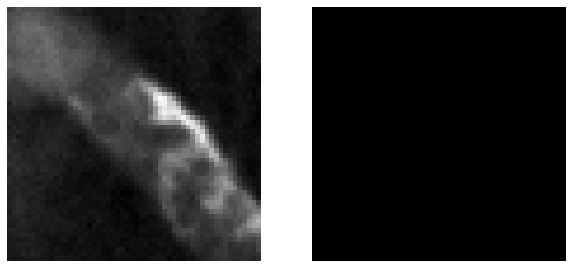

In [108]:
# quick snippet to check how predictions look

test_img_id = db.df[db.df.img_id == 20587612].index.values[0] #((2767, 2781), (1029, 1043))	
test_img = db[test_img_id]['img']
test_mask = db[test_img_id]['lesion_mask']
delta = 20
ppx1, ppx2, ppy1, ppy2 = 2115, 2129, 1657, 1671
simple_im_show2(test_img[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta])

In [109]:
# calculating final FROC curve points

tprs = []
fpis = []
for i in tqdm(range(1, len(froc_aggr_all_df))):
    df_slice = froc_aggr_all_df.type.values[:i]
    tp_count = (df_slice == 'TP').sum()
    fp_count = (df_slice == 'FP').sum()
    tpr = tp_count/(tp_count + len(FN))
    fpi = fp_count/(149)
    
    tprs.append(tpr)
    fpis.append(fpi)
    
    if fpi > 50:
        break

  5%|▍         | 9054/184668 [00:01<00:27, 6320.25it/s] 


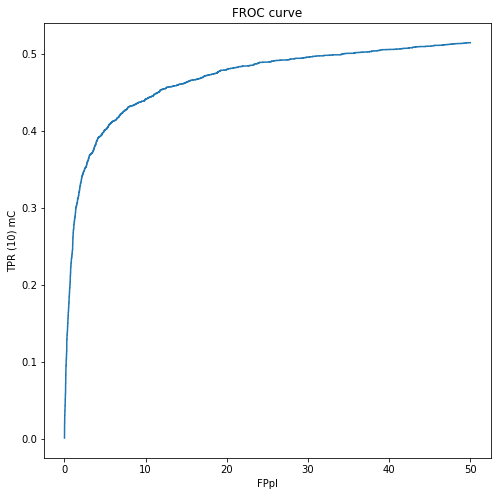

In [110]:
plt.figure(figsize=(8, 8))
plt.xlabel('FPpI')
plt.ylabel(f'TPR ({10}) mC')
plt.title('FROC curve')
plt.plot(fpis, tprs)
plt.show()

In [111]:
print(f"AUC: {auc(fpis, tprs)}")

AUC: 23.311766455244324
